This notebook is part of [miubrt](https://github.com/meteo-ubonn/miubrt).

Copyright (c) [miubrt developers](https://github.com/meteo-ubonn/miubrt/blob/main/CONTRIBUTORS.txt). 
Distributed under the MIT License. See [LICENSE.txt](https://github.com/meteo-ubonn/miubrt/blob/main/LICENSE.txt) for more info.

# Obtain calibration offset for ZH and ZDR
<div class="alert alert-info">

**User Info** <br>
 Global Data - User Input 
   start_time, end_time, location, par, fil_create, thrnan, thrbin, fname_ppi, fname_ver
   location = "BoXPol" or "JuXPol"  (X-band radar)
   par contains multiple attributes which needs to be tuned
    
 ZDR calibration uses "Bird Bath" method with azimuthal averaging
    
 ZH calibration then uses iterative solution with calibrated ZDR,  using ZH vs ZDR relationship based on  Rhyzkhov 2019 for X-band to compute the offset with least rmsd.
    
 This is a research code!
   
</div>
 

In [83]:
import sys
import warnings
warnings.filterwarnings('ignore')

In [84]:
import datetime as dt
import numpy as np
import scipy
from scipy import stats
import dask
import wradlib as wrl
import xarray as xr
#

In [85]:
# for using local development version, uncomment next lines otherwise installed `miubrt` version will be used
miubrt_dir = "../../"
if sys.path[0] != miubrt_dir:
     sys.path.insert(0, "../../")

In [86]:
import miubrt as mrt

# Global Data - USER INPUT

In [109]:
start_time = dt.datetime(2015, 7, 5, 0, 0)
end_time   = dt.datetime(2015, 7, 5, 23, 59, 59)
location   = "BoXPol"

class par:
    rhohv_th   = 0.97    #to remove hail
    phidp_th   = 10.0    #attenuation constraint
    dbz_th     = 30.0    #light rain
    dbz_thm    = 10.0    #for rain
    z_melt     = 4000.   #only below melting layer (JOYCE data)
    z_noise    = 1200.    #for ground clutter

fil_create = False
thrnan     = 10000   #threshold of number of zdr data (not nan) vertical scan
thrbin     = 100     #threshold of number of data available per bin for ZH calibration
fname_ppi  = "/data/hubhome/pshrestha/netcdf4/20150705/calib/BoXPol_010_20150705_0000_0000.nc"
fname_ver  = "/data/hubhome/pshrestha/netcdf4/20150705/calib/BoXPol_900_20150705_0000_0000.nc"
# User Input End #

#Climatological data (Ryzkhov 2019)
zh_X = np.array([20.,22.,24.,26.,28.,30.])
zdr_X = np.array([0.23,0.28,0.33,0.41,0.44,0.58])
#
    
if location == "BoXPol":
    sname  = "n_vertical_scan"
    sweep  = 0
elif location == "JuXPol":
    sname  = "Vert"
    sweep = 0
output_path = ""

# Create Netcdf Dataset of wanted radar data

In [110]:
if (fil_create):
    fname_ver = mrt.io.create_netcdf_dataset(location, sname, start_time, end_time, sweep, 
                                         outpath=output_path, engine='h5netcdf', chunks=None)

# Load and Explore Dataset

In [111]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from matplotlib import gridspec
from scipy.optimize import curve_fit
import hvplot
import hvplot.xarray
import holoviews as hv

## Load

In [112]:
swp = xr.open_dataset(fname_ver,chunks={"time": 12})
swp = swp.pipe(wrl.georef.georeference_dataset)
swp  = swp.chunk()
#
swp2 = xr.open_dataset(fname_ppi,chunks={"time": 12})
swp2 = swp2.pipe(wrl.georef.georeference_dataset)
swp2  = swp2.chunk()

## Extract masked polarimetric moments

In [113]:
i = 0
zh, zdr, kdp, rhohv, phidp, z = mrt.pol.calib_mask(swp,i, par)

## Select time with rain above radar

In [114]:
ndims = zdr.shape
st =[]
sctr =[]
for t in range(ndims[0]):
    ctr = np.count_nonzero(~np.isnan(zdr[t]))
    if (ctr > thrnan):
        print(t,ctr)
        st.append(t)
        sctr.append(ctr)

88 18488
99 35624
101 36638
222 12803
224 22671
243 26481


In [115]:
t=st[0]

## Diagnostic Plots - PPI

In [116]:
colors = ('#00f8f8', '#01b8fb', '#0000fa', '#00ff00', '#00d000', '#009400', 
          '#ffff00', '#f0cc00', '#ff9e00', '#ff0000', '#e40000', '#cc0000', 
          '#ff00ff', '#a06cd5')

dbz_levels=  [ -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
#zdr_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 1.2, 1.5, 2.0, 2.5, 3.0]
zdr_levels = np.arange(0,1.3,0.1) -1.5
kdp_levels = [-1., -0.5, -0.1, 0.0, 0.05, 0.10, 0.20, 0.30, 0.40, 0.60, 0.80, 1., 2., 3.]
rho_levels = [0.7,0.8, 0.85, 0.9, 0.92, 0.94, 0.95, 0.96, 0.97, 0.98, 0.985, 0.99, 0.995, 1.0] 
phi_levels = [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
z_levels   = [par.z_noise,par.z_melt-2000.,par.z_melt,par.z_melt+2000.]

(-2.0, 2.0)

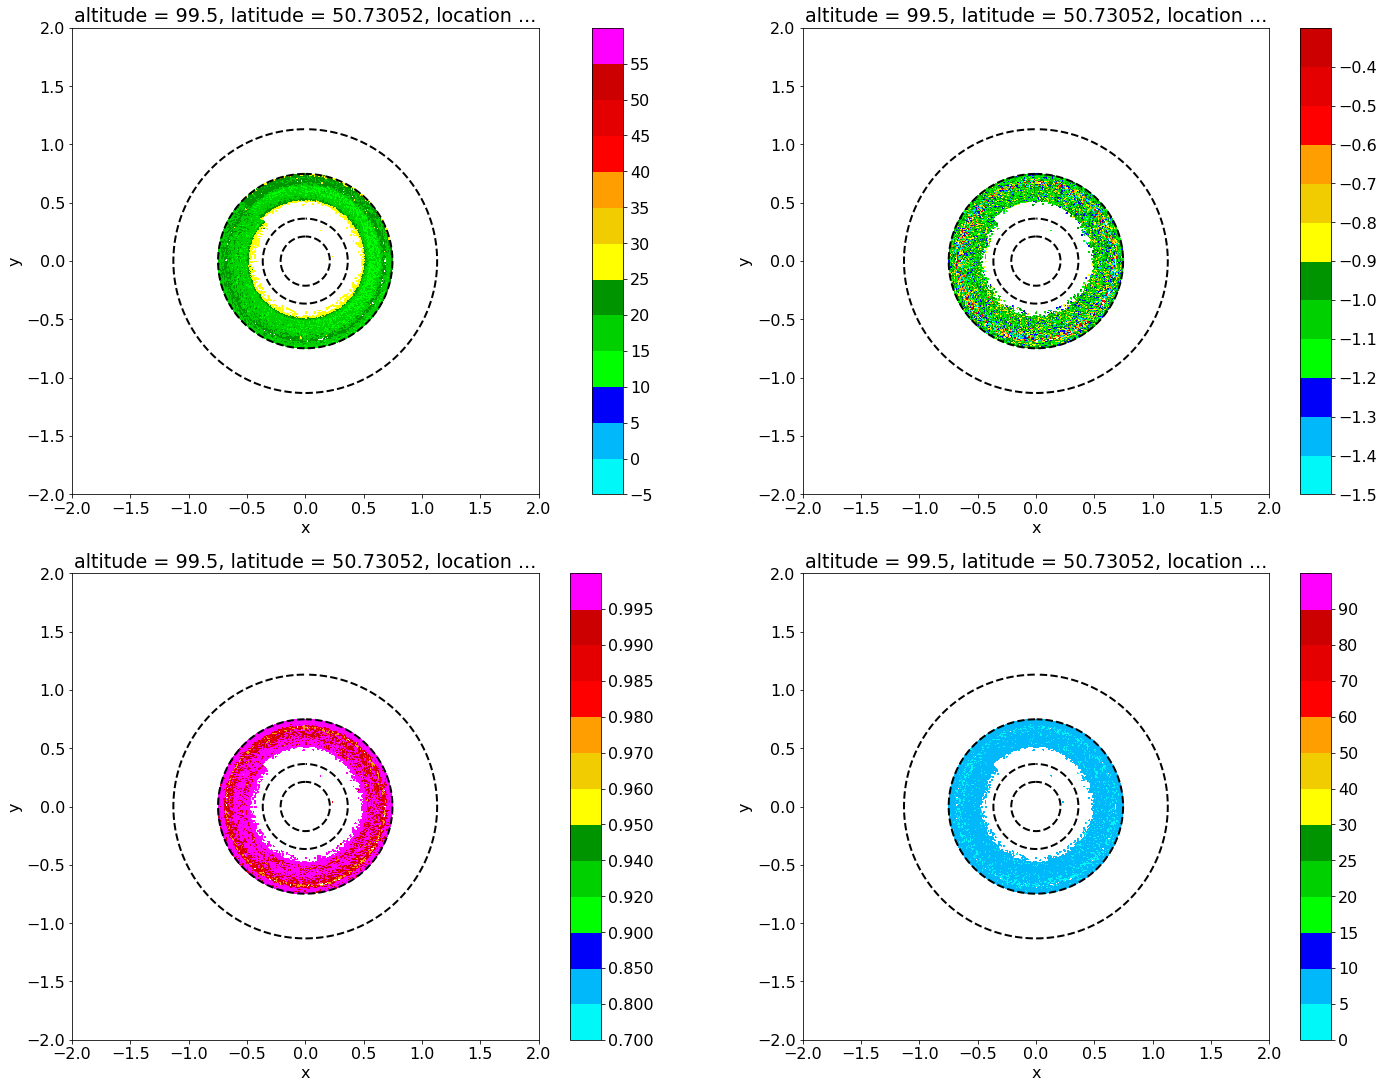

In [117]:
fig = plt.figure(figsize=(20,15),constrained_layout=True)
gs = gridspec.GridSpec(2, 2,fig)
boxminmax = [-2,2,-2,2]
xmin = boxminmax[0]
xmax = boxminmax[1]
ymin = boxminmax[2]
ymax = boxminmax[3]
#
ax0 = fig.add_subplot(gs[0,0])
p0 = zh[t].wradlib.plot_ppi( cmap=False,
                               levels=dbz_levels,
                               colors=colors, extend='neither',
                               add_colorbar=True, 
                               cbar_kwargs={'ticks': dbz_levels[0:-1]},
                               ax=ax0
                              )
z.plot.contour(x='x', y='y',levels = z_levels,
                 colors=('k',),linestyles=('--',),linewidths=(2,))
ax0.set_xlim([xmin,xmax])
ax0.set_ylim([ymin,ymax])
#
ax1 = fig.add_subplot(gs[0,1:])
p1 = zdr[t].wradlib.plot_ppi( cmap=False,
                               levels=zdr_levels,
                               colors=colors, extend='neither',
                               add_colorbar=True, 
                               cbar_kwargs={'ticks': zdr_levels[0:-1]},
                               ax=ax1
                              )
z.plot.contour(x='x', y='y',levels = z_levels,
                 colors=('k',),linestyles=('--',),linewidths=(2,))
ax1.set_xlim([xmin,xmax])
ax1.set_ylim([ymin,ymax])
#
ax2 = fig.add_subplot(gs[1:,0])
p2 = rhohv[t].wradlib.plot_ppi( cmap=False,
                               levels=rho_levels,
                               colors=colors, extend='neither',
                               add_colorbar=True, 
                               cbar_kwargs={'ticks': rho_levels[0:-1]},
                               ax=ax2
                              )
z.plot.contour(x='x', y='y',levels = z_levels,
                 colors=('k',),linestyles=('--',),linewidths=(2,))
ax2.set_xlim([xmin,xmax])
ax2.set_ylim([ymin,ymax])
#
ax3 = fig.add_subplot(gs[1:,1:])
p3 = phidp[t].wradlib.plot_ppi( cmap=False,
                               levels=phi_levels,
                               colors=colors, extend='neither',
                               add_colorbar=True, 
                               cbar_kwargs={'ticks': phi_levels[0:-1]},
                               ax=ax3
                              )
z.plot.contour(x='x', y='y',levels = z_levels,
                 colors=('k',),linestyles=('--',),linewidths=(2,))
ax3.set_xlim([xmin,xmax])
ax3.set_ylim([ymin,ymax])

## Diagnostic Plots - height_time contour

In [118]:
# Select any azimuth index
azid  = 130  

In [119]:
zh_2d      = zh[:,azid,:].transpose("range","time")
zdr_2d      = zdr[:,azid,:].transpose("range","time")

(0.0, 4000.0)

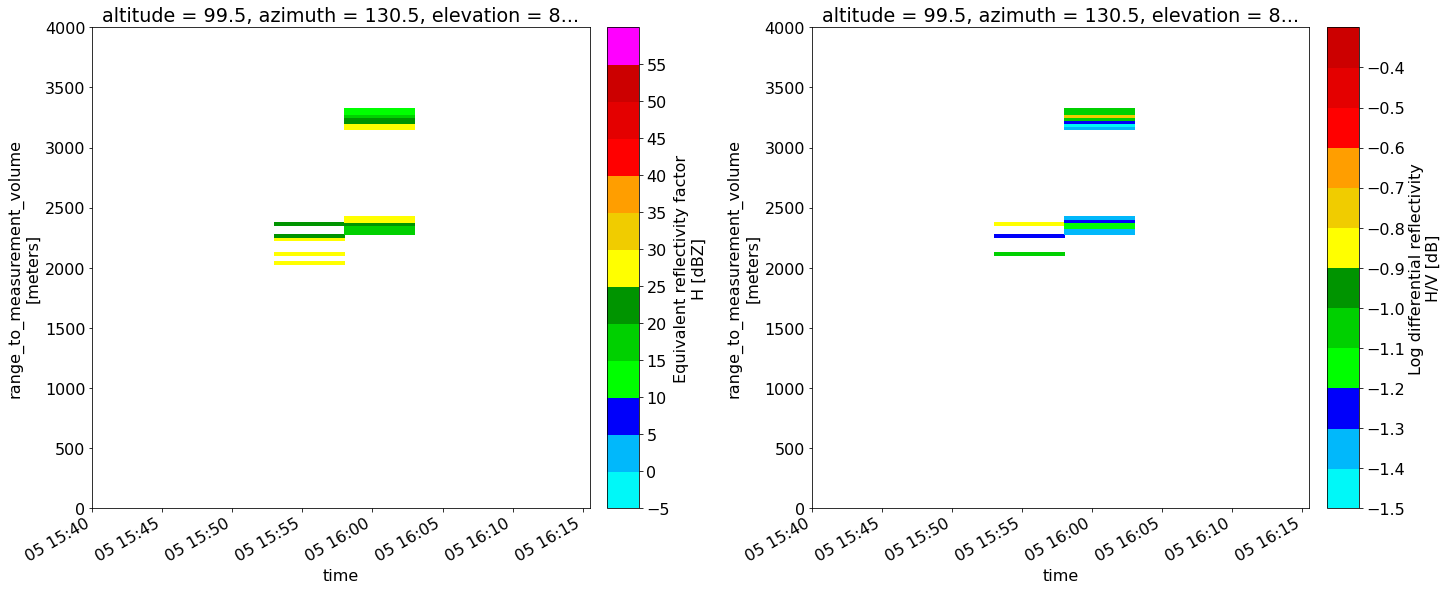

In [120]:
xmin = np.array('2015-07-05T15:40:00.000000000', dtype='datetime64[ns]')
xmax = np.array('2015-07-05T16:15:30.000000000', dtype='datetime64[ns]')
ymin = 0
ymax = par.z_melt
fig = plt.figure(figsize=(20,15),constrained_layout=True)
gs = gridspec.GridSpec(2, 2,fig)
ax0 = fig.add_subplot(gs[0,0])
p0 = zh_2d.plot(levels=dbz_levels,
                               colors=colors, extend='neither',
                               add_colorbar=True, 
                               cbar_kwargs={'ticks': dbz_levels[0:-1]},ax=ax0)
ax0.set_xlim([xmin,xmax])
ax0.set_ylim([ymin,ymax])
#
ax1 = fig.add_subplot(gs[0,1:])
p1 = zdr_2d.plot(levels=zdr_levels,
                               colors=colors, extend='neither',
                               add_colorbar=True, 
                               cbar_kwargs={'ticks': zdr_levels[0:-1]},ax=ax1)
ax1.set_xlim([xmin,xmax])
ax1.set_ylim([ymin,ymax])

## Compute ZDR calibration offset

In [121]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    zdr_crop  = zdr[st]
    sbins = np.arange(-2.5, 2.5, 0.1)
    cbins = np.arange(-2.45, 2.45, 0.1)
    counts, bins = np.histogram(zdr_crop,sbins)

counts = counts/sum(counts)
#
zdr_avg = zdr_crop.mean(('azimuth','range'))
zdr_offset = zdr_avg.values.round(2)
print("ZDR calibration offset = ", zdr_offset)
zdr_tavg = np.mean(zdr_avg)
zdr_avg_offset = zdr_tavg.values.round(2)
print("ZDR average calibration offset = ", zdr_avg_offset)

[########################################] | 100% Completed |  5.2s
ZDR calibration offset =  [-1.05 -1.03 -1.02 -1.09 -1.07 -0.94]
ZDR average calibration offset =  -1.03


### ZDR Historgram

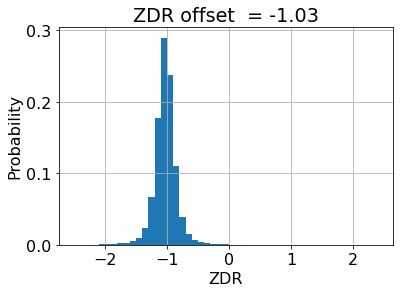

In [122]:
plt.hist(bins[:-1], bins, weights=counts)
plt.xlabel('ZDR')
plt.ylabel('Probability')
plt.title('ZDR offset  = ' + str(zdr_avg_offset))
plt.grid(True)

## Add offset to ZDR

In [123]:
zdr_corr = zdr - zdr_avg_offset
zdr_levels_corr = zdr_levels - zdr_avg_offset

## Updated ZDR plots

(-2.0, 2.0)

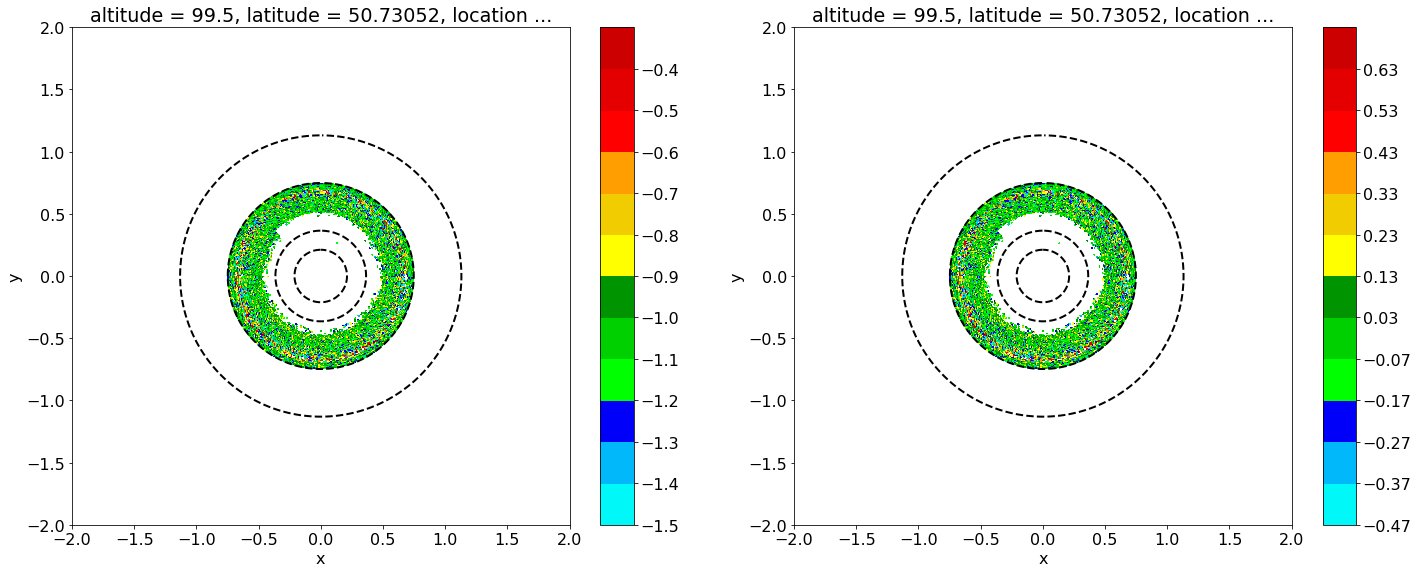

In [124]:
fig = plt.figure(figsize=(20,15),constrained_layout=True)
gs = gridspec.GridSpec(2, 2,fig)
boxminmax = [-2,2,-2,2]
xmin = boxminmax[0]
xmax = boxminmax[1]
ymin = boxminmax[2]
ymax = boxminmax[3]
#
ax0 = fig.add_subplot(gs[0,0])
p0 = zdr[t].wradlib.plot_ppi( cmap=False,
                               levels=zdr_levels,
                               colors=colors, extend='neither',
                               add_colorbar=True, 
                               cbar_kwargs={'ticks': zdr_levels[0:-1]},
                               ax=ax0
                              )
z.plot.contour(x='x', y='y',levels = z_levels,
                 colors=('k',),linestyles=('--',),linewidths=(2,))
ax0.set_xlim([xmin,xmax])
ax0.set_ylim([ymin,ymax])
#
ax1 = fig.add_subplot(gs[0,1:])
p1 = zdr_corr[t].wradlib.plot_ppi( cmap=False,
                               levels=zdr_levels_corr,
                               colors=colors, extend='neither',
                               add_colorbar=True, 
                               cbar_kwargs={'ticks': zdr_levels_corr[0:-1]},
                               ax=ax1
                              )
z.plot.contour(x='x', y='y',levels = z_levels,
                 colors=('k',),linestyles=('--',),linewidths=(2,))
ax1.set_xlim([xmin,xmax])
ax1.set_ylim([ymin,ymax])


## Clear data

In [125]:
del zh, zdr, kdp, rhohv, phidp, z

# ZH Calibration Offset Estimate

In [126]:
i=0
swp3 = swp2.copy()
#correct phase offset first
swp3['PHIDP'] = mrt.pol.phase_offset(swp2)
#Filter data
zh, zdr, kdp, rhohv, phidp, z = mrt.pol.calib_mask(swp3,i, par)

[########################################] | 100% Completed | 28.1s


## Dynamic diagnostic plots

In [127]:
pvar  = zh
plevs = dbz_levels
pol_plot = pvar.hvplot.quadmesh(groupby='time',x='x', y='y', 
                   frame_width=300, aspect=1, rasterize=True,
                   clim=(min(plevs),max(plevs)), cmap=colors)
pol_plot = pol_plot.options(color_levels=list(plevs))
pol_plot

:DynamicMap   [time]
   :Image   [x,y]   (DBZH)

In [ ]:
#Initialize data for linear fit
rmsd =[]
slope_data =[]
intercept_data =[]

#Reshape and remove NaN data
from dask.diagnostics import ProgressBar
with ProgressBar():
    xdata = zh.values.flatten()   
    x     = xdata[np.logical_not(np.isnan(xdata))]
    ydata = zdr.values.flatten()   
    y     = ydata[np.logical_not(np.isnan(xdata))]

#Estimate median ZDR via ZH binning, and count available data per bin
db = 1. # resolution of ZH bin
zh_bin_bdr = np.arange(par.dbz_thm-db/2.,par.dbz_th+db/2,db) 
ndim = len(zh_bin_bdr)-1
zdr_bin    = np.empty(ndim)
zh_bin     = np.empty(ndim)
ctr_bin    = np.empty(ndim)
for ss in range(ndim):
    zh_bin[ss] = 0.5*(zh_bin_bdr[ss] + zh_bin_bdr[ss+1] )
    tdata = np.where(((x > zh_bin_bdr[ss]) & (x <= zh_bin_bdr[ss+1])),y,np.nan)
    ctr_bin[ss] = tdata.size - np.isnan(tdata).sum()  
    if (ctr_bin[ss]>thrbin):
        zdr_bin[ss] = np.nanmedian(tdata)
    else:
        zdr_bin[ss] = np.nan       

#Find first index where number of data per bin is greater than threshold for Ryzkhov light rain
zh_start = zh_bin[np.argmax(ctr_bin > thrbin)]
istart    = np.argmax(zh_X > zh_start)
print("Difference computed >", zh_start, istart)

#Use only ZH data > zh_start
x     = np.where((x>zh_start),x,np.nan)
y     = np.where((x>zh_start),y,np.nan)
xnew  = x[np.logical_not(np.isnan(x))]
ynew  = y[np.logical_not(np.isnan(y))]

#Calibrate ZDR data
ycal  = ynew - zdr_avg_offset
zdr_bin = zdr_bin - zdr_avg_offset

#Iterate over a range of ZH offset
zh_offset = np.arange(-5.,5.,1.0)
for ioff in zh_offset:
    xcal     = xnew - ioff
    slope, intercept, r_value, p_value, std_err = stats.linregress(xcal,ycal)
    zdr_pred = slope * zh_X + intercept
    # Only compute rmsd difference for data > thrbin
    val = np.sqrt(((zdr_pred[istart:] - zdr_X[istart:]) ** 2).mean())
    #print(ioff, 'rmsd:', val)
    rmsd.append(val)
    slope_data.append(slope)
    intercept_data.append(intercept)

# Select offset with minimum difference
irdx = np.argmin(rmsd)
zh_avg_offset = zh_offset[irdx]
print("ZH_calibration_offset: ",zh_avg_offset, "rmsd: ",rmsd[irdx])

#Estimate the prediction based on linear fits
slope = slope_data[irdx]
intercept = intercept_data[irdx]
zdr_pred = slope * zh_X + intercept

#Calibrate ZH data
xcal     = xnew - zh_avg_offset
zh_bin   = zh_bin - zh_avg_offset

[###############################         ] | 79% Completed | 23.0s

## Diagnostic Plot - Zh vs Calibrated ZDR, with estimates

In [ ]:
#Scatter plot 
fig = plt.figure(figsize=(20,15),constrained_layout=True)
ax0 = fig.add_subplot(231)
from dask.diagnostics import ProgressBar
with ProgressBar():
    p0 = plt.scatter(xcal, ycal, c="g", alpha=0.5)

plt.grid(True)
lines   = plt.plot(zh_bin,zdr_bin,'k--')
lines   = plt.plot(zh_X,zdr_X,'r-')
lines   = plt.plot(zh_X[istart:],zdr_pred[istart:],'b-')
#-- get window ID from the first plot
my_plot = plt.gca()
ax0.set_ylim([-0.5,3.0])

## Print esitmated calibration offset parameters

In [131]:
print("ZDR calibration offset ", zdr_avg_offset)
print("ZH calibration offset ", zh_avg_offset)

ZDR calibration offset  -1.03
ZH calibration offset  -3.0
